In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import six
from scipy import signal, linalg
import h5py
import glob
import pmefm
import lockin
from freqdemod import h5ls
from collections import OrderedDict
from enum import Enum
from munch import Munch
from decorator import decorator
from kpfm.util import h5filename

Mod = Enum('Mod', 'x y xy')

@h5filename
def _h5toPMEFM(f, mod_direction):
    """For today's data (2017-02-22), note that the gains are all equal"""
    phi_t = f['CPD'][:]
    fs = f.attrs['Inputs.Scan rate [Hz]']
    dt = 1/fs
    T = phi_t.size * dt
    fx = f.attrs['Inputs.Pos Mod Freq (Hz)']
    if mod_direction == Mod.xy:
        scale_factor = 2
    else:
        scale_factor = np.sqrt(2)
    x_m = f.attrs['Inputs.Pos Mod rms (V)'] * scale_factor * 15 * 0.125 # 125 nm/V
    d = {key.replace("Inputs.", ""): val for key, val in fh.attrs.items()}
    X0 = d['X Start [V]']
    Y0 = d['Y Start [V] ']
    Xf = d['X End [V]']
    Yf = d['Y End [V] ']
    start = X0 + 1j * Y0
    end = Xf + 1j * Yf
    scan = end - start
    scan_size = abs(scan)
    x_tot = scan_size * 0.125  # 125 nm / V
    v_tip = x_tot / T

    return Munch({'fs': fs, 'fx': fx, 'v_tip': v_tip, 'x_m': x_m, 'phi_t': phi_t})

def workup_file(fh_or_fname, mod_direction, fir, invert=False,
                x_m=None, plot_phase=True, iprint=0):
    pm = pmefm.PMEFMEx(**_h5toPMEFM(fh_or_fname, mod_direction))
    if x_m is not None:
        pm.x_m = x_m
    pm.fir_filter(fir_ac=fir, fir_dc=fir)
    pm.auto_phase(invert=invert, iprint=iprint)
    if plot_phase:
        pm.plot_phase()
    pm.output()
    return pm


def workup_dict(d, mod_direction, fir, replace_xm=True, plot_phase=True, iprint=0):
    if replace_xm:
        return OrderedDict(
    (key, workup_file(fname, Mod.xy, fir, invert, float(key)/1000.0,
                      plot_phase=plot_phase, iprint=iprint))
        for (key, (fname, invert)) in d.items()
            )
    else:
        return OrderedDict(
    (key, workup_file(fname, Mod.xy, fir, invert,
                      plot_phase=plot_phase, iprint=iprint))
        for (key, (fname, invert)) in d.items()
            )


def plot_dict(pall, rcParams={'figure.figsize': (3.5, 3.5)}, samefig=False):
    for i, pm in enumerate(pall.values()):
        if i > 0 and samefig:
            figax = (fig, axes)
        else:
            figax = None
        fig, axes = pm.plot_output(rcParams=rcParams, figax=figax)
        for ax in axes:
            ax.grid(color='0.6', linestyle=":", zorder=0)
        axes[1].set_ylim(-1.25, 0.35)
        axes[0].legend()
    
    return fig, axes

def align_labels(axes_list,lim, axis='y'):
    for ax in axes_list:
        t = ax.yaxis.label.get_transform()
        x,y = ax.yaxis.label.get_position()
        ax.yaxis.set_label_coords(lim,y,t)

ks = 19772.0
plt.rc('font', size=9)
plt.rc('text', usetex=False)

In [3]:
fh = h5py.File('../data/KPFM-linescans/170222-1511DPh-BTBT-20V-scan-y-45-nm-y-mod.h5', 'r')

In [4]:
d = _h5toPMEFM(fh, mod_direction=Mod.xy)

In [5]:
fir = lockin.lock2(1e3, 1.1, 4.4, d.fs/d.v_tip)

Response:
f   mag       dB
   0.000 1.000    0.000
   0.550 0.983   -0.151
   1.100 0.927   -0.656
   4.400 0.095  -20.488
   8.800 0.000 -101.830
 500.000 0.000 -270.187
1000.000 0.000 -270.321
11037.642 0.000 -345.562


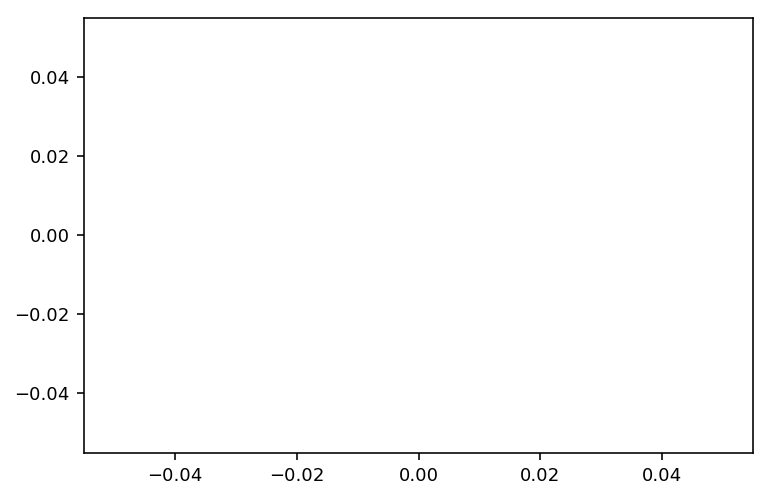

In [6]:
colors = [plt.plot(0,0)[0].get_color() for i in xrange(6)]

In [7]:
ymod = OrderedDict([
    (0, ('../data/KPFM-linescans/170222-1512DPh-BTBT-20V-scan-y-no-mod.h5', False)),
    (15, ('../data/KPFM-linescans/170222-1507DPh-BTBT-20V-scan-y-15-nm-y-mod.h5', True)),
    (30, ('../data/KPFM-linescans/170222-1508DPh-BTBT-20V-scan-y-30-nm-y-mod.h5', False)),
    (45, ('../data/KPFM-linescans/170222-1511DPh-BTBT-20V-scan-y-45-nm-y-mod.h5', False))
])

In [8]:
py = workup_dict(ymod, Mod.y, fir, plot_phase=False)

/Users/ryandwyer/Documents/Research/workups/1704-pmkpfm/src/lockin/pmefm.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  self.k0_dc = jn_zeros(0, 1)[0] / (2 * np.pi * x_m)
/Users/ryandwyer/Documents/Research/workups/1704-pmkpfm/src/lockin/pmefm.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  self.k0_ac = jn_zeros(1, 1)[0] / (2 * np.pi * x_m)
/Users/ryandwyer/Documents/Research/workups/1704-pmkpfm/src/lockin/pmefm.py:438: RuntimeWarning: divide by zero encountered in true_divide
  self.E_mod = self.V_ac / self.x_m


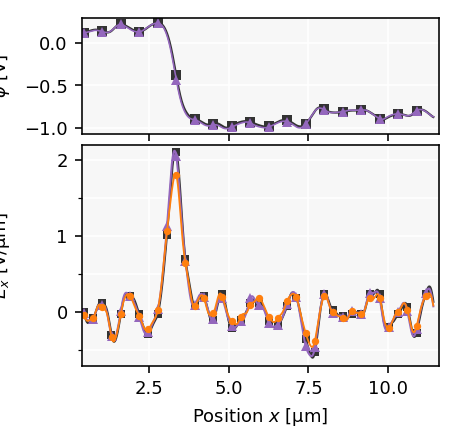

In [29]:
plt.rc('font', size=9)
plt.rc('text', usetex=False)
# plt.rcParams.update({'mathtext.fontset':'cm'})

fig = plt.figure(figsize=(3.2, 3.2))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=(1, 1.9))
gs.update(hspace=0.063)
ax2 = plt.subplot(gs[0], facecolor='0.97')
ax1 = plt.subplot(gs[1], facecolor='0.97', sharex=ax2)
# ax1.set_axisbelow(True)
# ax2.set_axisbelow(True)
ax1.grid(which='both', color='1', linestyle='-', linewidth=0.75)
ax2.grid(which='both', color='1', linestyle='-', linewidth=0.75)
# plt.setp(ax1.get_xticklabels(), visible=False)
efm = py[0]
dec = 40
dec_pts = 160
i = dec_pts*dec//3 * 2
scale = 3.5
ax1.plot(efm('x_dc')[::dec], efm('E_dc')[::dec], '0.2', linewidth=1.1)
ax1.plot(efm('x_dc')[::(dec_pts*dec)],
             efm('E_dc')[::(dec_pts*dec)],
             linewidth=0, marker='s', markersize=1.2*scale, mew=0, alpha=1, color='0.2')
ax2.plot(efm('x_dc')[::dec], efm('phi_dc')[::dec], '0.2', linewidth=1.1)
ax2.plot(efm('x_dc')[::(dec_pts*dec*2)], efm('phi_dc')[::(dec_pts*dec*2)], '0.2',
         linewidth=0, marker='s', markersize=1.35*scale, mew=0, alpha=1, color='0.2')

c1 = u'#9467bd'
c2 = '#ff7f0e'
for efm in [py[i] for i in [30]]:
    line, = ax1.plot(efm('x_dc')[::dec], efm('E_dc')[::dec], alpha=1, linewidth=1, color=c1)
    ax1.plot(efm('x_dc')[i::(dec_pts*dec)],
             efm('E_dc')[i::(dec_pts*dec)],
             linewidth=0, marker='^', mew=0, markersize=1.35*scale, alpha=1, color=line.get_color())
    line2, = ax1.plot(efm('x_dc')[::dec], efm('E_mod')[::dec], alpha=1, linewidth=0.9, color=c2)
    ax1.plot(efm('x_dc')[i::(dec_pts*dec)],
             efm('E_mod')[i::(dec_pts*dec)],
             linewidth=0, marker='.', markersize=2.1*scale, mew=0, alpha=1, color=line2.get_color())

    ax2.plot(efm('x_dc')[::dec], efm('phi_dc')[::dec],
             alpha=1, linewidth=0.8, color=c1)
    ax2.plot(efm('x_dc')[i::(dec_pts*dec*2)], efm('phi_dc')[i::(dec_pts*dec*2)], alpha=1,
             linewidth=0, marker='^', mew=0, markersize=1.35*scale, color=c1)

    
ax1.set_ylabel(u"$E_{x}$ [V/µm]")
ax1.set_xlabel(u"Position $x$ [µm]")
ax2.set_ylabel(u"$\\phi$ [V]")
align_labels([ax1, ax2], 12)
ax1.set_xlim(0.4, 11.6)
ax2.set_xlim(0.4, 11.6)
ax1.set_xticks(np.arange(2.5, 11.5, 2.5))
ax2.set_xticks(np.arange(2.5, 11.6, 2.5))
ax1.set_ylim(-0.7, 2.2)
ax1.set_yticks(np.arange(0, 2.1, 1))
# ax1.set_yticklabels(['0', '1', '2'])
ax1.set_yticks(np.arange(-0.5, 1.6, 1), minor=True)

In [30]:
fig.savefig('../figs/02cd-pm-parallel.pdf', bbox_inches='tight', pad_inches=0.2)

In [25]:
!open ../figs/02cd-pm-parallel.pdf